In [16]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import FlagserPersistence
from gtda.diagrams import BettiCurve
import matplotlib.pyplot as plt
import gudhi as gd
from gtda.plotting import plot_diagram
import pandas as pd
import glob
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file)
    return game_data

def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    counts = [pass_info["count"] for player in game for pass_info in player["passes"]]
    max_count = max(counts)
    min_count = min(counts)

    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))

    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]

            edge_weight = 1 - (count - min_count) / (max_count - min_count)

            # round to 3 decimal places
            edge_weight = round(edge_weight, 3)

            G.add_edge(player1, player2, weight=edge_weight)

    return G

def compute_persistence_stats(diagrams):
    diagrams = np.array(diagrams)
    
    # Separate Betti0 (H0) and Betti1 (H1)
    h0_data = diagrams[diagrams[:, 2] == 0]
    h1_data = diagrams[diagrams[:, 2] == 1]
    
    # Compute persistence (Death - Birth)
    persistence_h0 = h0_data[:, 1] - h0_data[:, 0]
    persistence_h1 = h1_data[:, 1] - h1_data[:, 0]
    
    # Compute average and standard deviation
    avg_h0 = np.mean(persistence_h0) if len(persistence_h0) > 0 else 0
    std_h0 = np.std(persistence_h0) if len(persistence_h0) > 0 else 0
    avg_h1 = np.mean(persistence_h1) if len(persistence_h1) > 0 else 0
    std_h1 = np.std(persistence_h1) if len(persistence_h1) > 0 else 0
    
    return {
        "Average H0": avg_h0,
        "Std H0": std_h0,
        "Average H1": avg_h1,
        "Std H1": std_h1
    }



def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes

def getAUC(game):
    current_game = load_game_data(game)
    G_example = construct_adjacency_matrix(current_game)

    fp = FlagserPersistence()
    adj_matrix, nodes = graph_to_adjacency_matrix(G_example)

    diagrams = fp.fit_transform([adj_matrix])[0]
    betti_transformer = BettiCurve(
        n_bins=100
    )

    betti_transformer = BettiCurve(n_bins=1000)
    betti_numbers = betti_transformer.fit_transform([diagrams])[0]

    filtration_values = np.linspace(0, 1, num=1000)

    betti0 = betti_numbers[0, :]
    betti1 = betti_numbers[1, :] if betti_numbers.shape[0] > 1 else None


    auc_betti0 = np.trapz(betti0, filtration_values)
    auc_betti1 = np.trapz(betti1, filtration_values) if betti1 is not None else 0

    return auc_betti0, auc_betti1


In [18]:
directory_path = '../data/2015-2016/1-Bundesliga/*.json'

auc_values = {}
persistence_stats = {}

for file_path in glob.glob(directory_path):
    filename = os.path.basename(file_path)
    filename_list = filename.split('_')
    team = filename_list[1]
    goals = int(filename_list[-2])
    minutes = int(filename_list[-1].split('.')[0])

    goal_per_90 = goals / (minutes / 90)

    auc_betti0, auc_betti1 = getAUC(file_path)
    auc_values[filename] = (auc_betti0, auc_betti1, goal_per_90)

    current_game = load_game_data(file_path)
    G_example = construct_adjacency_matrix(current_game)
    adj_matrix, nodes = graph_to_adjacency_matrix(G_example)

    fp = FlagserPersistence()
    diagrams = fp.fit_transform([adj_matrix])[0]  # Persistence diagram

    # Compute persistence stats
    stats = compute_persistence_stats(diagrams)
    stats["Goals per 90"] = goal_per_90

    # Aggregate stats by team
    if team not in persistence_stats:
        persistence_stats[team] = []
    persistence_stats[team].append(stats)

/Users/mertbildirici/Library/Python/3.9/lib/python/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/mertbildirici/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/mertbildirici/Library/Python/3.9/lib/python/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/mertbildirici/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/mertbildirici/Library/Python/3.9/lib/python/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/mertbildirici/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in sub

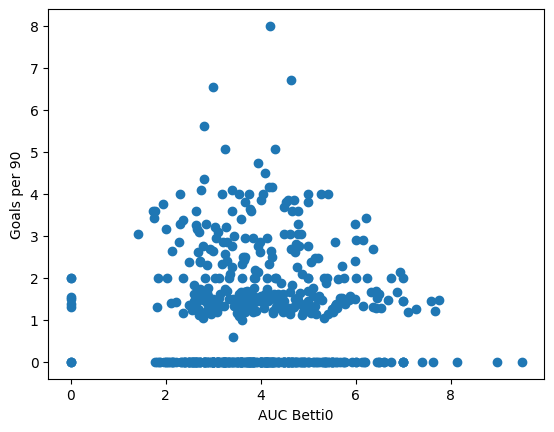

Correlation Betti0: -0.018348404267773868
Correlation Betti1: -0.06396269514038863


In [19]:
auc_values_list = list(auc_values.values())
auc_values_list = np.array(auc_values_list)
plt.scatter(auc_values_list[:, 1], auc_values_list[:, 2])
plt.xlabel("AUC Betti0")
plt.ylabel("Goals per 90")
plt.show()

correlation_betti0 = np.corrcoef(auc_values_list[:, 1], auc_values_list[:, 2])[0, 1]
correlation_betti1 = np.corrcoef(auc_values_list[:, 0], auc_values_list[:, 2])[0, 1]

print(f"Correlation Betti0: {correlation_betti0}")
print(f"Correlation Betti1: {correlation_betti1}")

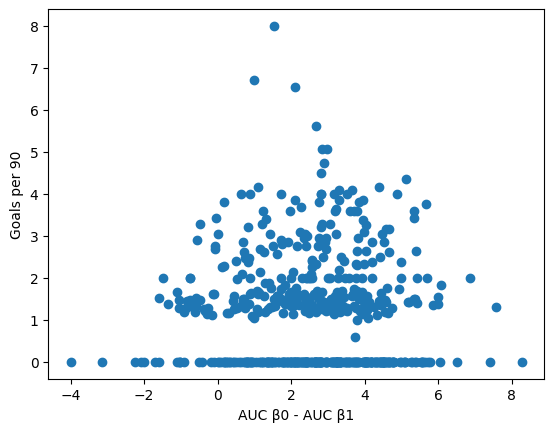

Correlation difference: -0.02233150391746788


In [20]:
# look at the difference between the two AUC values and plot it against the goals per 90
auc_diff = auc_values_list[:, 0] - auc_values_list[:, 1]
plt.scatter(auc_diff, auc_values_list[:, 2])
plt.xlabel("AUC β0 - AUC β1")
plt.ylabel("Goals per 90")
plt.show()
correlation_difference = np.corrcoef(auc_diff, auc_values_list[:, 2])[0, 1]
print(f"Correlation difference: {correlation_difference}")

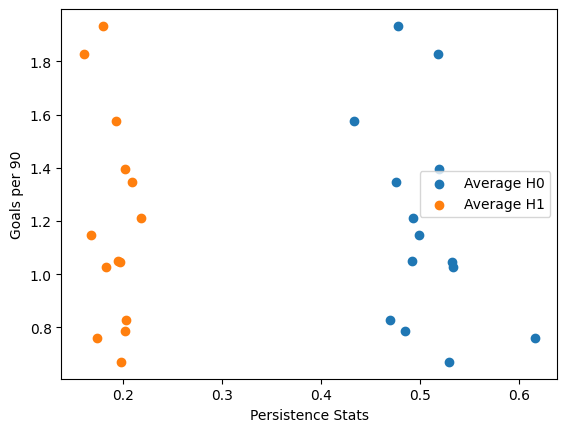

Correlation between Average H0 and Goals per 90: -0.40321508957182495
Correlation between Average H1 and Goals per 90: -0.3077696879888242


In [21]:
team_stats = {}
for team, stats_list in persistence_stats.items():
    stats_df = pd.DataFrame(stats_list)
    team_stats[team] = stats_df.mean().to_dict()


team_stats_df = pd.DataFrame.from_dict(team_stats, orient='index')
team_stats_df = team_stats_df.dropna()  # Remove rows with NaN
team_stats_df = team_stats_df[np.isfinite(team_stats_df).all(axis=1)]  # Remove rows with Inf

plt.scatter(team_stats_df["Average H0"], team_stats_df["Goals per 90"], label="Average H0")
plt.scatter(team_stats_df["Average H1"], team_stats_df["Goals per 90"], label="Average H1")
plt.xlabel("Persistence Stats")
plt.ylabel("Goals per 90")
plt.legend()
plt.show()

correlation_avg_h0 = team_stats_df["Average H0"].corr(team_stats_df["Goals per 90"])
correlation_avg_h1 = team_stats_df["Average H1"].corr(team_stats_df["Goals per 90"])
print(f"Correlation between Average H0 and Goals per 90: {correlation_avg_h0}")
print(f"Correlation between Average H1 and Goals per 90: {correlation_avg_h1}")


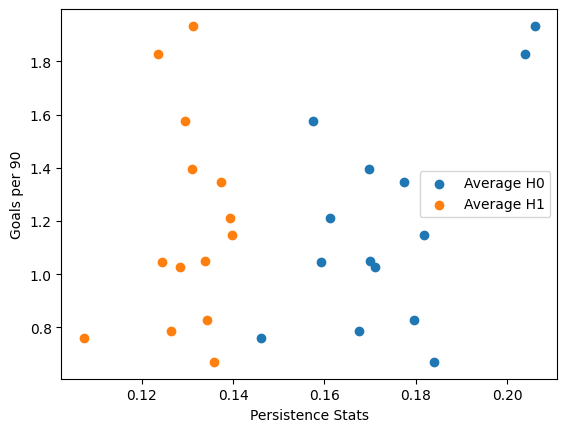

Correlation between Std H0 and Goals per 90: 0.5419448953331937
Correlation between Std H1 and Goals per 90: 0.12002616033114334


In [25]:
plt.scatter(team_stats_df["Std H0"], team_stats_df["Goals per 90"], label="Average H0")
plt.scatter(team_stats_df["Std H1"], team_stats_df["Goals per 90"], label="Average H1")
plt.xlabel("Persistence Stats")
plt.ylabel("Goals per 90")
plt.legend()
plt.show()

correlation_avg_h0 = team_stats_df["Std H0"].corr(team_stats_df["Goals per 90"])
correlation_avg_h1 = team_stats_df["Std H1"].corr(team_stats_df["Goals per 90"])
print(f"Correlation between Std H0 and Goals per 90: {correlation_avg_h0}")
print(f"Correlation between Std H1 and Goals per 90: {correlation_avg_h1}")

In [22]:
# Features and target
X = team_stats_df[["Average H0", "Std H0", "Average H1", "Std H1"]]
y = team_stats_df["Goals per 90"]

# Fit the regression model
model = LinearRegression()
model.fit(X, y)

# Predict and compute R^2
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print("R^2:", r2)


R^2: 0.4850331722791532
